In [120]:
#Mounting colab to read the data from google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
#imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

from datetime import datetime

from plotly.subplots import make_subplots
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from collections import Counter
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Load data

In [122]:
hospital_data = pd.read_csv("/content/drive/MyDrive/hospital_mortality.csv")
hospital_data.head(5)

,PATIENT_ID,Age,Gender,Height,ICUType,BUN_Min,Creatinine_Min,GCS_Min,Glucose_Min,HCO3_Min,HCT_Min,HR_Min,K_Min,Mg_Min,NIDiasABP_Min,NIMAP_Min,NISysABP_Min,Na_Min,PaCO2_Min,PaO2_Min,Platelets_Min,Temp_Min,Urine_Min,WBC_Min,Weight_Min,pH_Min,BUN_Max,Creatinine_Max,GCS_Max,Glucose_Max,HCO3_Max,HCT_Max,HR_Max,K_Max,Mg_Max,NIDiasABP_Max,NIMAP_Max,NISysABP_Max,Na_Max,PaCO2_Max,...,Glucose_Median,HCO3_Median,HCT_Median,HR_Median,K_Median,Mg_Median,NIDiasABP_Median,NIMAP_Median,NISysABP_Median,Na_Median,PaCO2_Median,PaO2_Median,Platelets_Median,Temp_Median,Urine_Median,WBC_Median,Weight_Median,pH_Median,BUN_Range,Creatinine_Range,GCS_Range,Glucose_Range,HCO3_Range,HCT_Range,HR_Range,K_Range,Mg_Range,NIDiasABP_Range,NIMAP_Range,NISysABP_Range,Na_Range,PaCO2_Range,PaO2_Range,Platelets_Range,Temp_Range,Urine_Range,WBC_Range,Weight_Range,pH_Range,In-hospital_death
0,132539.0,54.0,0.0,-1.0,4.0,8.0,0.7,14.0,115.0,26.0,30.3,58.0,4.0,1.5,39.0,58.67,96.0,136.0,NaN,NaN,185.0,35.1,0.0,9.4,-1.0,NaN,13.0,0.8,15.0,205.0,28.0,33.7,86.0,4.4,1.9,67.0,92.33,157.0,137.0,NaN,...,160.0,27.0,33.5,73.0,4.2,1.70,49.0,70.000,110.0,136.5,NaN,NaN,203.0,37.70,100.0,10.3,-1.0,NaN,5.0,0.1,1.0,90.0,2.0,3.4,28.0,0.4,0.4,28.0,33.66,61.0,1.0,NaN,NaN,36.0,3.1,900.0,1.8,0.0,NaN,0
1,132540.0,76.0,1.0,175.3,2.0,16.0,0.8,3.0,105.0,21.0,24.7,65.0,3.5,1.9,38.0,49.33,72.0,135.0,33.0,82.0,135.0,34.5,0.0,7.4,76.0,7.34,21.0,1.3,15.0,146.0,24.0,30.7,90.0,4.3,3.1,67.0,88.33,131.0,139.0,46.0,...,125.5,22.0,28.8,80.0,3.9,2.10,59.0,78.165,115.0,137.0,40.0,153.0,181.0,37.45,90.0,13.1,80.6,7.4,5.0,0.5,12.0,41.0,3.0,6.0,25.0,0.8,1.2,29.0,39.00,59.0,4.0,13.0,363.0,91.0,3.4,770.0,5.9,5.6,0.11,0
2,132541.0,44.0,0.0,-1.0,3.0,3.0,0.3,5.0,119.0,24.0,26.7,57.0,2.3,1.3,66.0,83.33,111.0,137.0,33.0,65.0,72.0,36.7,18.0,3.7,56.7,7.47,8.0,0.4,8.0,143.0,26.0,29.4,113.0,8.6,1.9,95.0,110.00,150.0,140.0,37.0,...,141.0,25.0,28.7,85.5,3.4,1.80,79.0,97.670,134.0,138.0,36.0,120.5,84.0,37.85,100.0,4.2,56.7,7.5,5.0,0.1,3.0,24.0,2.0,2.7,56.0,6.3,0.6,29.0,26.67,39.0,3.0,4.0,167.0,41.0,2.3,407.0,2.5,0.0,0.04,0
3,132543.0,68.0,1.0,180.3,3.0,10.0,0.7,14.0,106.0,27.0,36.1,57.0,3.8,1.9,45.0,68.33,102.0,137.0,NaN,NaN,284.0,35.1,100.0,7.9,84.6,NaN,23.0,0.9,15.0,129.0,28.0,41.3,88.0,4.2,2.1,81.0,100.70,140.0,141.0,NaN,...,117.0,28.0,36.8,74.0,4.0,2.10,64.0,83.670,120.0,140.0,NaN,NaN,315.0,36.40,625.0,8.8,84.6,NaN,13.0,0.2,1.0,23.0,1.0,5.2,31.0,0.4,0.2,36.0,32.37,38.0,4.0,NaN,NaN,107.0,1.9,600.0,3.6,0.0,NaN,0
4,132545.0,88.0,0.0,-1.0,3.0,25.0,1.0,15.0,92.0,18.0,22.6,65.0,3.8,1.5,26.0,52.33,105.0,139.0,NaN,NaN,97.0,35.8,16.0,3.8,-1.0,NaN,45.0,1.0,15.0,113.0,20.0,32.4,94.0,6.0,1.6,96.0,105.70,157.0,140.0,NaN,...,102.5,19.0,30.6,73.0,3.9,1.55,42.0,75.330,131.0,139.5,NaN,NaN,103.0,37.00,50.0,4.3,-1.0,NaN,20.0,0.0,0.0,21.0,2.0,9.8,29.0,2.2,0.1,70.0,53.37,52.0,1.0,NaN,NaN,12.0,2.0,204.0,1.0,0.0,NaN,0


### How many patients have 20 or more missing feature values? 

**Explanation:** To get this value, I first checked the basic structure of the dataset and the column names. After that I counted the numbers of missing features for each row and filtered the patient_IDs with missing features equal to or greater than 20. 

#### Patient ID's with 20 or more missing values: 210

In [123]:
print("Dimension of Dataset:", hospital_data.shape )
print("Column names:", hospital_data.columns)

lst = []
for i in range(0,len(hospital_data.index)):
  lst.append([i, hospital_data.iloc[i].isnull().sum()])

missingfeature = pd.DataFrame(lst,columns = ["patient_index", "missing_feature_count"])

missingfeature = missingfeature[missingfeature.missing_feature_count >= 20]

print("Patients with 20 or more missing values:", missingfeature.shape[0])

Dimension of Dataset: (4000, 111)
Column names: Index(['PATIENT_ID', 'Age', 'Gender', 'Height', 'ICUType', 'BUN_Min',
       'Creatinine_Min', 'GCS_Min', 'Glucose_Min', 'HCO3_Min',
       ...
       'Na_Range', 'PaCO2_Range', 'PaO2_Range', 'Platelets_Range',
       'Temp_Range', 'Urine_Range', 'WBC_Range', 'Weight_Range', 'pH_Range',
       'In-hospital_death'],
      dtype='object', length=111)
Patients with 20 or more missing values: 210


### What’s the difference in means of HR_min for patients that died vs survived (not counting patients with HR_min of  0)?

**Explanation**:To calculate this, I first filtered the rows which do not have HR_min = 0. Then I filtered the mean of HR_min for patients who died and patients who survived and took the difference of both the values.

#### Difference in means of HR_min for patients that died vs survived: 1.6746

In [124]:
## Your code here
hospital_data = hospital_data[hospital_data.HR_Min != 0]
hospital_data_died = hospital_data[hospital_data["In-hospital_death"] == 1]
died_mean = hospital_data_died.HR_Min.mean()
hospital_data_survived = hospital_data[hospital_data["In-hospital_death"] == 0]
survived_mean = hospital_data_survived.HR_Min.mean()
print("Difference in means of HR_min for patients that died vs survived:", round((died_mean - survived_mean),4))

Difference in means of HR_min for patients that died vs survived: 1.6746


### What is the median maximum heart rate for patients whose maximum temperature was 2 degrees Celsius higher than their minimum temperature?

**Explanation** : For this Question, I filter the rows with patients with difference in max and min temperature to 2 degree celsius. I then calculated the median of Maximum heart rate.

#### Median maximum heart rate for patients whose maximum temperature was 2 degrees Celsius higher than their minimum temperature: 109.0 

In [125]:
## Your code here
hospital_data_new= hospital_data[(hospital_data.Temp_Max  - hospital_data.Temp_Min) == 2]
print("Median maximum heart rate for patients whose maximum temperature was 2 degrees \
Celsius higher than their minimum temperature:",hospital_data_new.HR_Max.median())

Median maximum heart rate for patients whose maximum temperature was 2 degrees Celsius higher than their minimum temperature: 109.0


### Create a plot to analyze the relationship between median temperature, outcome (died vs. survived), and age.

**Explanation:** We can observe that our Age and Temp_Median are both continous variables. I used KBinsDiscretizer to discritize the Age variable into 4 bin. The discretization is done on the quantiled values, which means that each bin has approximately the same number of samples and plotted it with respect to the Temp_median for for survived and dead patients. Here 0 label is for survived patients and 1 is for died patients. We can observe that for all the bins, our distribution of median temperatures for survived case are centered around 37 degree celsius with less variation in survivors as compared to the dead patients. We can also observe that the first two bins have higher variation along with outliers in median temperature as compared to 3rd and the 4th bin.

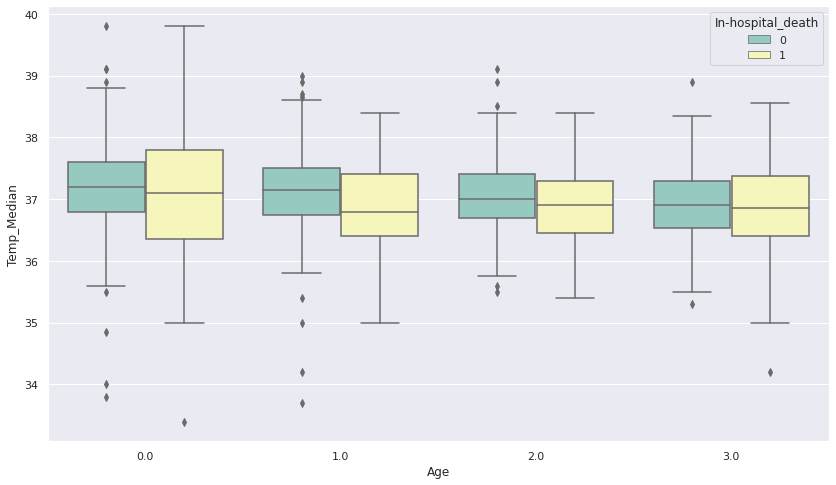

In [126]:
from sklearn.preprocessing import KBinsDiscretizer as KD
plt.figure(figsize=(14,8))
sns.set_theme(style="darkgrid")
bin = KD(n_bins=4, encode='ordinal', strategy='quantile')
transBinned = np.array(hospital_data['Age']).reshape(-1,1)
bin.fit(transBinned)
hospital_data['Age'] = bin.transform(transBinned)
ax = sns.boxplot(x="Age", y="Temp_Median", hue="In-hospital_death",
                 data=hospital_data, palette="Set3")


### Create a plot to analyze the relationship between median temperature, outcome (died vs. survived), and gender.

**Explanation:** I first checked the unique values in the gender feature and I observed, there were 3 rows with -1 values as gender which is not possible.

- Gender 0: Females
- Gender 1: Males

Therefore, I dropped those rows with -1 as gender and then plotted the gender with the median temperature keeping In-hospital deaths as hue to check for both the cases. We can observe that for both males and females the mean is same both male and female survivor as well as male and female deid in hospital. From the plot, we are not able to obverse much difference for both males and females in both survived and died-in-hopital case.

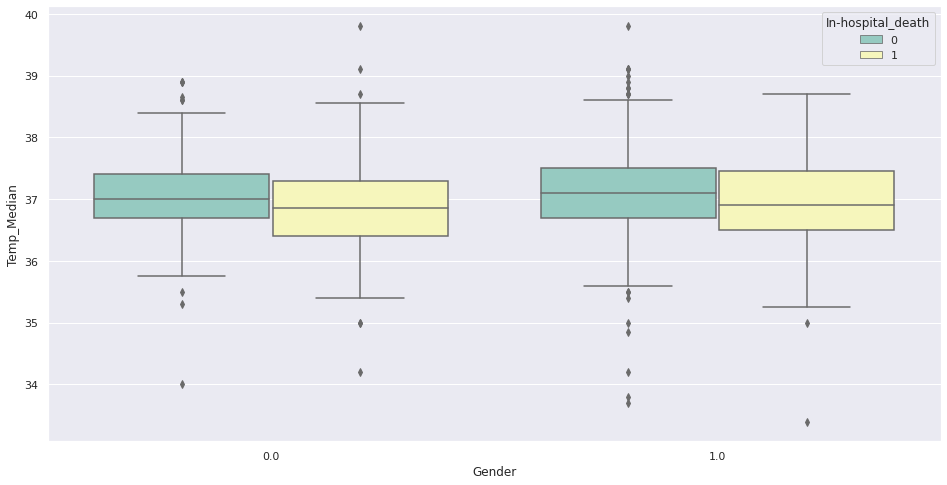

In [127]:
## Your code here
plt.figure(figsize=(16,8))
hospital_data_gender = hospital_data[hospital_data.Gender != -1]
ax = sns.boxplot(x="Gender", y="Temp_Median", hue="In-hospital_death",
                 data=hospital_data_gender, palette="Set3")

### Build and summarize the results of a machine learning model that predicts whether a patient dies or survives in the hospital. (We do not expect a perfect or highest-accuracy solution; this is primarily an opportunity for you to show your machine learning project workflow and to document your thought process, approach to solving problems, and interpretation of results.)

##### Checking the datatypes of columns and missing values

**Observation:** We can observe that out of 111 featues 100 features have missing values. All the features are continous.

In [128]:
#checking datatype
hospital_data.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [129]:
#checking missing value counts
missing_values = []
missing_values = [[feature,hospital_data[feature].isnull().sum(), np.round(hospital_data[feature].isnull().mean()*100,4)] for feature in hospital_data]
df = pd.DataFrame(missing_values, columns=["Features", "Count","Missing_value_percent"])
df = df[df.Count >0]
df

,Features,Count,Missing_value_percent
5,BUN_Min,64,1.6044
6,Creatinine_Min,64,1.6044
7,GCS_Min,64,1.6044
8,Glucose_Min,113,2.8328
9,HCO3_Min,76,1.9052
...,...,...,...
104,Platelets_Range,68,1.7047
105,Temp_Range,64,1.6044
106,Urine_Range,117,2.9331
107,WBC_Range,73,1.8300


In [130]:
#Count of unique values in the categorical features
summarystats_categorical_feat = []
categorical_feature = [feature for feature in hospital_data.columns if hospital_data[feature].dtype == 'O']
summarystats_categorical_feat = [[feature, len(hospital_data[feature].unique())] for feature in categorical_feature]
df = pd.DataFrame(summarystats_categorical_feat, columns=["Features", "Unique Categories"])
df.shape[0]

0

##### **Handling missing values**

In our dataset the missing values present are less than 30% in all the features with missing values. In this case imputing missing values with mean or median is the best option on the basis of the distribution of the data. Since most features has normal distribution, I am using mean to impute the missing values.

In [131]:
#Imputing missing data with mean
hospital_data=hospital_data.fillna(hospital_data.mean())

##### **Handling unrealistic data**

We can observe from the describe funtion that few of the featues have negative values too which is not possible in a lot of cases. Next, I checked the featues with negative values to identify the realisticness of the data or to impute those data points with relevant data.

I found that 'Gender', 'Height','Temp_Min','Weight_Min','Weight_Max','Weight_Mean','Weight_Median' have negative values. I performed the following imputions:

**Gender:** I imputed the Gender values having -1 with higher mode which is for label 1.

**Height:** We can observe that we have few rows with negative height (-1) which is not possible. I imputed the height with th mean value.

**Min temp:** We can observe that we have min temperatues [-17.8 -12.5]. For dead patient case negative temperature could be possible but it is not possible for the survived patients. I imputed survived patient's temperature (-12.5) with mean min temperature.

**Weight Min:** We can observe that negative min weight is -1 which is not possible so I replaced the values with mean value.

**Weight Max:** We can observe that negative max weight is -1 which is not possible so I replaced the values with mean value.

**Weight Mean:** We can observe that negative mean weight is -1 which is not possible so I replaced the values with mean value.

**Weight Max:** We can observe that negative median weight is -1 which is not possible so I replaced the values with mean value.

In [132]:
#Description of dataset
hospital_data.describe()

,PATIENT_ID,Age,Gender,Height,ICUType,BUN_Min,Creatinine_Min,GCS_Min,Glucose_Min,HCO3_Min,HCT_Min,HR_Min,K_Min,Mg_Min,NIDiasABP_Min,NIMAP_Min,NISysABP_Min,Na_Min,PaCO2_Min,PaO2_Min,Platelets_Min,Temp_Min,Urine_Min,WBC_Min,Weight_Min,pH_Min,BUN_Max,Creatinine_Max,GCS_Max,Glucose_Max,HCO3_Max,HCT_Max,HR_Max,K_Max,Mg_Max,NIDiasABP_Max,NIMAP_Max,NISysABP_Max,Na_Max,PaCO2_Max,...,Glucose_Median,HCO3_Median,HCT_Median,HR_Median,K_Median,Mg_Median,NIDiasABP_Median,NIMAP_Median,NISysABP_Median,Na_Median,PaCO2_Median,PaO2_Median,Platelets_Median,Temp_Median,Urine_Median,WBC_Median,Weight_Median,pH_Median,BUN_Range,Creatinine_Range,GCS_Range,Glucose_Range,HCO3_Range,HCT_Range,HR_Range,K_Range,Mg_Range,NIDiasABP_Range,NIMAP_Range,NISysABP_Range,Na_Range,PaCO2_Range,PaO2_Range,Platelets_Range,Temp_Range,Urine_Range,WBC_Range,Weight_Range,pH_Range,In-hospital_death
count,3989.000000,3989.000000,3989.000000,3989.00000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.00000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,...,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.00000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.00000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000
mean,137609.115066,1.542241,0.561043,88.92018,2.759338,21.922548,1.183465,8.224968,108.574045,21.853974,28.634854,68.680362,3.759363,1.788394,39.872481,59.080055,90.485362,136.918242,34.587417,92.294977,179.500128,35.03358,24.229933,10.366530,74.184796,7.369967,29.302420,1.559924,13.535796,173.395769,25.434449,34.149936,112.473816,4.559183,2.256897,79.287853,96.721624,143.804535,140.722024,47.500996,...,133.431244,23.667263,31.461159,86.404865,4.113768,2.014861,56.74266,75.866802,117.186711,138.896270,40.088147,133.980910,204.122928,37.053834,102.197701,12.425066,76.907837,7.456905,7.379873,0.376459,5.310828,64.821723,3.580475,5.515083,43.793454,0.799820,0.468502,39.415371,37.64157,53.319173,3.803781,12.913579,157.473948,54.586075,2.895389,587.043311,4.585074,3.602700,0.726180,0.137378
std,2923.895346,1.123976,0.497835,86.54287,1.002625,18.540452,1.199375,4.765314,29.430194,4.477530,5.310748,13.938818,0.510529,0.337027,13.192869,13.451419,25.364703,4.379211,6.807744,37.012591,98.396839,5.94393,47.583314,5.506778,31.859429,1.945997,23.041936,1.640506,2.566968,86.288820,4.036737,4.757522,22.181206,0.816324,0.421724,18.055763,17.705781,25.372718,4.387955,9.686472,...,37.271578,4.087949,4.528674,14.883055,0.479565,0.306791,11.32873,11.674636,18.783060,4.116118,6.788831,47.864885,102.745625,0.593803,115.882611,6.559862,32.094083,2.070182,8.490460,0.630853,4.373394,86.180797,2.741864,3.993169,20.457798,0.793525,0.419421,21.550619,20.37715,31.601523,3.232363,8.702139,105.091520,48.354729,5.973654,574.462265,4.853197,10.983307,16.633622,0.344289
min,132539.000000,0.000000,-1.000000,-1.00000,1.000000,0.000000,0.100000,3.000000,10.000000,5.000000,9.000000,3.500000,1.800000,0.600000,0.000000,0.000000,0.000000,98.000000,0.300000,0.000000,6.000000,-17.80000,0.000000,0.100000,-1.000000,1.000000,3.000000,0.200000,3.000000,60.000000,11.000000,18.600000,53.000000,2.500000,1.100000,0.000000,0.000000,0.000000,119.000000,16.000000,...,49.000000,8.000000,14.800000,40.000000,2.500000,1.100000,0.00000,0.000000,0.000000,111.500000,14.000000,26.000000,11.500000,33.400000,0.000000,0.100000,-1.000000,7.105000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [133]:
#Columns with negative values
print(hospital_data.columns[(hospital_data< 0).any()].tolist())

['Gender', 'Height', 'Temp_Min', 'Weight_Min', 'Weight_Max', 'Weight_Mean', 'Weight_Median']


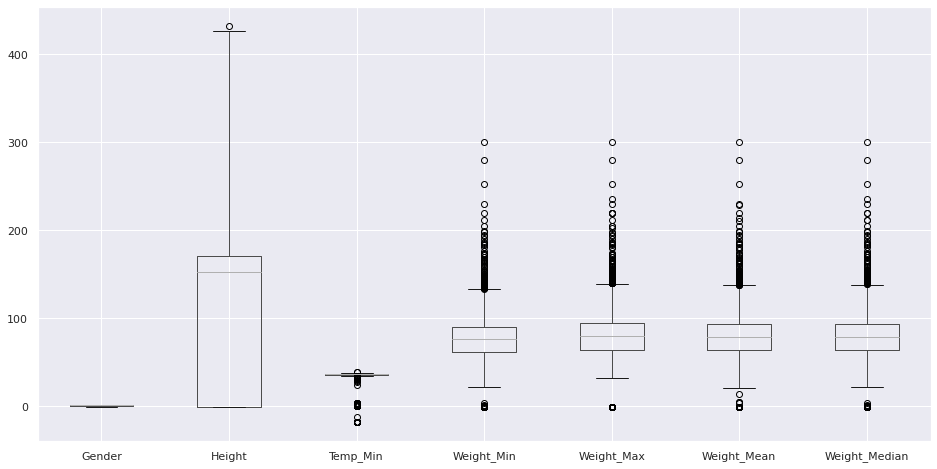

In [134]:
plt.figure(figsize=(16,8))
hospital_data.boxplot(column=['Gender', 'Height','Temp_Min','Weight_Min','Weight_Max','Weight_Mean','Weight_Median'])

###### **Gender**

In [135]:
#Imputing negative gender values
print("Gender with their counts:",hospital_data.groupby(by = 'Gender').size())
hospital_data['Gender'] = hospital_data['Gender'].replace(-1.0,1.0)

Gender with their counts: Gender
-1.0       3
 0.0    1745
 1.0    2241
dtype: int64


###### **Height**

In [136]:
#Imputing negative height values
print(hospital_data[hospital_data.Height < 0]['Height'].unique())
hospital_data['Height'] = hospital_data['Height'].replace(-1.0,hospital_data['Height'].mean())

[-1.]


###### **Min Temp**

In [137]:
#Imputing negative Min temperature values
print("Patients with negative temperature:",hospital_data[(hospital_data.Temp_Min < 0)].shape[0])
print("Negative temperatuer values:",hospital_data[(hospital_data.Temp_Min < 0)]['Temp_Min'].unique())
print("Dead patients with negative temperature:",hospital_data[(hospital_data.Temp_Min < 0) & (hospital_data['In-hospital_death'] == 1)]['Temp_Min'])
hospital_data['Temp_Min'] = hospital_data['Temp_Min'].replace(-12.5,hospital_data['Temp_Min'].mean())

Patients with negative temperature: 24
Negative temperatuer values: [-17.8 -12.5]
Dead patients with negative temperature: 608    -17.8
1858   -17.8
2093   -17.8
Name: Temp_Min, dtype: float64


###### **Weight Min**

In [138]:
#Imputing negative min weight values
print(hospital_data[hospital_data['Weight_Min'] < 0]['Weight_Min'].unique())
hospital_data['Weight_Min'] = hospital_data['Weight_Min'].replace(-1.0,hospital_data['Weight_Min'].mean())

[-1.]


###### **Weight Max**

In [139]:
##Imputing negative max weight values
print(hospital_data[hospital_data['Weight_Max'] < 0]['Weight_Max'].unique())
hospital_data['Weight_Max'] = hospital_data['Weight_Max'].replace(-1.0,hospital_data['Weight_Max'].mean())

[-1.]


###### **Weight Mean**

In [140]:
#Imputing negative mean weight values
print(hospital_data[hospital_data['Weight_Mean'] < 0]['Weight_Mean'].unique())
hospital_data['Weight_Mean'] = hospital_data['Weight_Mean'].replace(-1.0,hospital_data['Weight_Mean'].mean())

[-1.]


###### **Weight Median**


In [141]:
#Imputing negative median weight values
hospital_data[hospital_data['Weight_Median'] < 0]['Weight_Median'].unique()
hospital_data['Weight_Median'] = hospital_data['Weight_Median'].replace(-1.0,hospital_data['Weight_Median'].mean())

###### **Feature Selection**

Feature selection is a very important step since we have **111 features** with only **3989 data points** thus our model might overfit and even a lot of features could be redundant with high correlation. I performed feature selection using correlation and p-value check to see if a particular feature is contributing to the prediction of target variable or not.

**correlation** I removed the one of the features from the two highly correlated featues. After performing this we got **74 featuers** which are not highly correlated.

**Feature Selection** Next we will be selecting the columns based on how they affect the p-value. We are the removing the target column because it is the column we are trying to predict.We assume to null hypothesis to be “The selected combination of dependent variables do not have any effect on the independent variable”. Then we build a small regression model and calculate the p values. If the p values is higher than the threshold, we discard that combination of features. We got to **23 features** after this step which contibutes the most to our target variable.


In [142]:
#shape of data
hospital_data.shape

(3989, 111)

In [143]:
#checking correlation between the features and removing one highly correlated featue.
corr = hospital_data.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = hospital_data.columns[columns]
hospital_data = hospital_data[selected_columns]

In [144]:
hospital_data.shape


(3989, 73)

In [145]:
selected_columns

Index(['PATIENT_ID', 'Age', 'Gender', 'Height', 'ICUType', 'BUN_Min',
       'Creatinine_Min', 'GCS_Min', 'Glucose_Min', 'HCO3_Min', 'HCT_Min',
       'HR_Min', 'K_Min', 'Mg_Min', 'NIDiasABP_Min', 'NIMAP_Min',
       'NISysABP_Min', 'Na_Min', 'PaCO2_Min', 'PaO2_Min', 'Platelets_Min',
       'Temp_Min', 'Urine_Min', 'WBC_Min', 'Weight_Min', 'pH_Min', 'GCS_Max',
       'Glucose_Max', 'HCO3_Max', 'HCT_Max', 'HR_Max', 'K_Max', 'Mg_Max',
       'NIDiasABP_Max', 'NISysABP_Max', 'Na_Max', 'PaCO2_Max', 'PaO2_Max',
       'Temp_Max', 'Urine_Max', 'WBC_Max', 'pH_Max', 'GCS_Mean',
       'Glucose_Mean', 'HR_Mean', 'K_Mean', 'Mg_Mean', 'NIDiasABP_Mean',
       'NIMAP_Mean', 'NISysABP_Mean', 'PaCO2_Mean', 'PaO2_Mean', 'Temp_Mean',
       'Urine_Mean', 'pH_Mean', 'Temp_Median', 'BUN_Range', 'Creatinine_Range',
       'GCS_Range', 'HCO3_Range', 'HCT_Range', 'HR_Range', 'K_Range',
       'Mg_Range', 'NIDiasABP_Range', 'NISysABP_Range', 'Na_Range',
       'PaCO2_Range', 'Platelets_Range', 'Temp_Range',

In [146]:
#Feature selection
selected_columns = selected_columns[1:]
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(hospital_data.iloc[:,1:].values, hospital_data.iloc[:,0].values, SL, selected_columns)



In [147]:
result = pd.DataFrame()
result['In-hospital_death'] = hospital_data.iloc[:,72]
result

,In-hospital_death
0,0
1,0
2,0
3,0
4,0
...,...
3995,0
3996,0
3997,0
3998,1


In [159]:
data = pd.DataFrame(data = data_modeled, columns = selected_columns)
data.shape
data.columns

Index(['Age', 'BUN_Min', 'GCS_Min', 'NIMAP_Min', 'Na_Min', 'Platelets_Min',
       'pH_Min', 'GCS_Max', 'HCO3_Max', 'HCT_Max', 'Mg_Max', 'Na_Max',
       'PaCO2_Max', 'PaO2_Max', 'Temp_Max', 'HR_Mean', 'K_Mean', 'NIMAP_Mean',
       'Temp_Median', 'BUN_Range', 'GCS_Range', 'NISysABP_Range',
       'In-hospital_death'],
      dtype='object')

#### **Dataset Splitting**

It is important to split the dataset into training data and testing data so as to hide the some datapoints while training the model and checking the model performance on the hidden(test data) for observing near real-time performance. I took a classic 80:20 % train:test ratio for train-test splitting. We can also observe that we have just 13% died--in-hospital patients and 86% survivors.

0.0    0.862622
1.0    0.137378
Name: In-hospital_death, dtype: float64


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Class'),
 Text(0.5, 1.0, 'Class Distribution')]

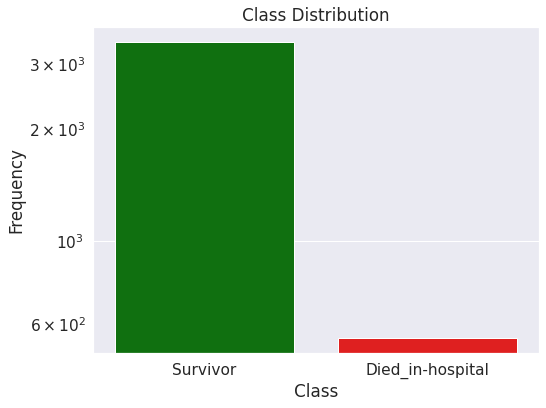

In [161]:
#Checking the distribution of our target variable
plt.figure(figsize=(8,6))
counts = data['In-hospital_death'].value_counts()
print(counts/data.shape[0])
labels = ['Survivor', 'Died_in-hospital']
ax = sns.barplot(x=labels, y=counts, log=True, palette=['green', 'red'])
ax.set(xlabel='Class', ylabel='Frequency', title='Class Distribution')

In [150]:
#Seperating features and target column
y = data.loc[:,'In-hospital_death']
data = data.drop(['In-hospital_death'], axis = 1)
X = data

In [151]:
#Train-test-split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify= y, \
                                                  test_size=0.20, random_state=42)
print(X_train.shape,y_train.shape)
print(X_val.shape, y_val.shape)
X_train = X_train.reset_index(drop =True)
y_train = y_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

(3191, 22) (3191,)
(798, 22) (798,)


#### **Modeling**

**Classification: Baseline Models**

I am using two standard baseline models to observe the model performance with the unbalanced dataset which we observed in the previous plot. Our aim is the predict whether patient dies or survives in the hospital from the models:

1. Logistic Regression
2. Random Forest

I have chosen logistic regression and random forest because, logistic regression is the most basic and highly used classification model applicable. Random forest is an advance model which can handle data imbalance well thus taking random forest too in consideration.

**Observations** From the model's results we can make following observations:

- Logistic Regression: From the confusion matrix of logistic regression, we can say that we are getting a very good prediction for the negative class which is survivor class (99 % recall) but our model is also not able to predict the true positive i.e. died In-hospital class (12 %). we also have a high false negative (88 %) which is bad for our us. Our aim should be to increase True positives prediction and decrease false negatives. We can say our model is predicting the died-in-hospital as survived due to the data imbalance.

- Random Forest: Our random forest model is also giving similar results, with only 28% True positives and 95% true negatives with very high false negative which should be less.





In [152]:
# fit a logistic regression model to the data
def logisticRegression(train_x, train_y,test_x, test_y):
  model = LogisticRegression(random_state= 42)
  model.fit(train_x, train_y)
  print(model)
  # make predictions
  expected = test_y
  predicted = model.predict(test_x)
  # summarize the fit of the model
  print(classification_report(expected, predicted))
  print(confusion_matrix(expected, predicted))
  disp = plot_confusion_matrix(model, test_x, test_y,
                                 cmap=plt.cm.Blues,normalize = 'true')
  disp.ax_.set_title("Confusion Matrix")
  plt.figure(figsize=(10,6))
  sns.set(font_scale=1.4)
  print("Confusion Matrix")
  plt.show()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       688
         1.0       0.65      0.12      0.20       110

    accuracy                           0.87       798
   macro avg       0.76      0.55      0.56       798
weighted avg       0.84      0.87      0.83       798

[[681   7]
 [ 97  13]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Confusion Matrix


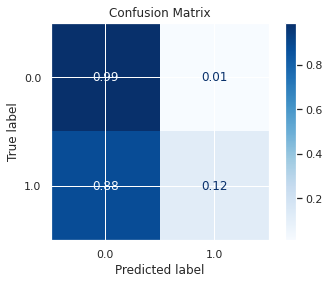

<Figure size 720x432 with 0 Axes>

None


In [153]:
#Predicting with logistive regression model
print(logisticRegression(X_train, y_train, X_val, y_val))

In [154]:
def randomForest(train_x, train_y,test_x, test_y):
  clf = RandomForestClassifier(n_estimators = 5, max_depth =35, random_state=0)
  clf.fit(train_x,train_y)
  print(classification_report(test_y, clf.predict(test_x)))
  print(confusion_matrix(test_y, clf.predict(test_x)))
  disp = plot_confusion_matrix(clf, test_x, test_y,
                                 cmap=plt.cm.Blues, normalize = 'true')
  disp.ax_.set_title("Confusion Matrix")
  print("Confusion Matrix")
  plt.show()

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       688
         1.0       0.50      0.28      0.36       110

    accuracy                           0.86       798
   macro avg       0.70      0.62      0.64       798
weighted avg       0.84      0.86      0.85       798

[[657  31]
 [ 79  31]]
Confusion Matrix


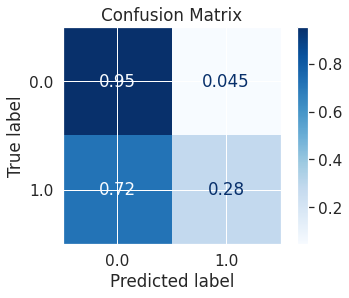

None


In [155]:
#Predicting with Random Forest model
print(randomForest(X_train, y_train, X_val, y_val))

##### **Over Sampling**

We can further try oversampling technique to handle the data imbalance. I am using SMOTE for oversampling. SMOTE(Synthetic Minority Oversampling Technique) is the most widely used approach to synthesizing new examples. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Synthetic over-sampling works to cause the classifier to build larger decision regions that contain nearby minority class points.

**Observation:** I made the following observations for both the models:

- Logistic regression: From the confustion matrix of logistic regression, we can say even though our true negative decreased to 76% but our true positive which is the more important class have increased to a very high value (72%) which is a very good number that our logistive regression model is giving after over sampling. We can further perform feature engineering and use advance models to increase this accuracy further. 

- Random Forest: Even though logistic regression performed well with oversampling Random forest couldn't perform very well in this case giving the true positives around 46% only. 

We can choose logistic regresion as the final model in this case.


In [156]:
#Oversampling
X_resampled, y_resampled = SMOTE().fit_sample(X_train,y_train)
counter = Counter(y_resampled)
print(counter)

Counter({1.0: 2753, 0.0: 2753})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84       688
         1.0       0.32      0.72      0.45       110

    accuracy                           0.75       798
   macro avg       0.63      0.74      0.64       798
weighted avg       0.86      0.75      0.79       798

[[522 166]
 [ 31  79]]
Confusion Matrix


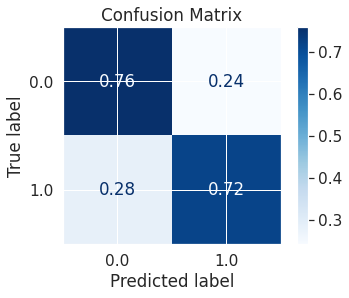

<Figure size 720x432 with 0 Axes>

None


In [157]:
#Predicting with logistive regression model
print(logisticRegression(X_resampled, y_resampled, X_val, y_val)) 

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       688
         1.0       0.41      0.46      0.43       110

    accuracy                           0.83       798
   macro avg       0.66      0.68      0.67       798
weighted avg       0.84      0.83      0.84       798

[[614  74]
 [ 59  51]]
Confusion Matrix


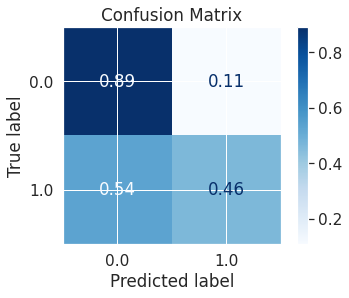

None


In [158]:
#Predicting with Random Forest model
print(randomForest(X_resampled, y_resampled, X_val, y_val))